In [2]:
'''
data_manager.py
A file that loads saved features and convert them into PyTorch DataLoader.
'''
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Class based on PyTorch Dataset|
class GTZANDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

# Function to get genre index for the given file
def get_label(file_name, hparams):
    genre = file_name.split('.')[0]
    label = hparams.genres.index(genre)

    return label

# Function for loading entire data from given dataset and return numpy array
def load_dataset(set_name, hparams):
    x = []
    y = []

    dataset_path = os.path.join(hparams.feature_path, set_name)
    for root,dirs,files in os.walk(dataset_path):
        for file in files:
            data = np.load(os.path.join(root,file))
            label = get_label(file, hparams)
            x.append(data)
            y.append(label)

    x = np.stack(x)
    y = np.stack(y)

    return x,y

# Function to load numpy data and normalize, it returns dataloader for train, valid, test
def get_dataloader(hparams):
    x_train, y_train = load_dataset('train', hparams)
    x_valid, y_valid = load_dataset('valid', hparams)
    x_test, y_test = load_dataset('test', hparams)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std
    x_test = (x_test - mean)/std

    train_set = GTZANDataset(x_train, y_train)
    valid_set = GTZANDataset(x_valid, y_valid)
    test_set = GTZANDataset(x_test, y_test)

    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(valid_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)

    return train_loader, valid_loader, test_loader

In [8]:
from matplotlib import pyplot as plt

In [9]:
x = []
y = []

dataset_path = os.path.join(hparams.feature_path, 'train')
for root,dirs,files in os.walk(dataset_path):
    for file in files:
        data = np.load(os.path.join(root,file))
        label = get_label(file, hparams)
        x.append(data)
        y.append(label)
        break

x = np.stack(x)
y = np.stack(y)

x.shape

(8, 1024, 128)

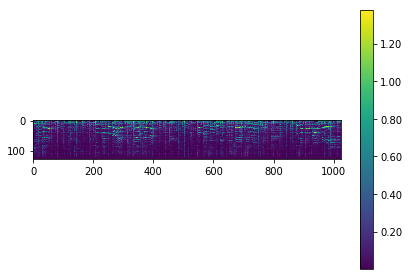

In [17]:
plt.imshow(np.transpose(data,[1,0]))

plt.colorbar(format='%1.2f')
plt.tight_layout()
plt.grid('off')
plt.show()

In [41]:
len('classical.00030.npy')

19

In [4]:
# import argparse

class HParams(object):
	def __init__(self):
		# Dataset Settings
		self.dataset_path = 'd:/다운로드/gtzan'
		self.feature_path = 'feature'
		self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

		# Feature Parameters
		self.sample_rate = 22050
		self.fft_size = 1024
		self.win_size = 1024
		self.hop_size = 512
		self.num_mels = 128
		self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

		# Training Parameters
		self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
		self.batch_size = 10
		self.num_epochs = 100
		self.learning_rate = 1e-2
		self.stopping_rate = 1e-12
		self.weight_decay = 1e-6
		self.momentum = 0.9
		self.factor = 0.2
		self.patience = 3.

# 	Function for parsing argument and set hyper parameters
# 	def parse_argument(self, print_argument=True):
# 		parser = argparse.ArgumentParser()
# 		for var in vars(self):
# 			value = getattr(hparams, var)
# 			argument = '--' + var
# 			parser.add_argument(argument, type=type(value), default=value)

# 		args = parser.parse_args()
# 		for var in vars(self):
# 			setattr(hparams, var, getattr(args, var))

# 		if print_argument:
# 			print('-------------------------')
# 			print('Hyper Parameter Settings')
# 			print('-------------------------')
# 			for var in vars(self):
# 				value = getattr(hparams, var)
# 				print(var + ': ' + str(value))
# 			print('-------------------------')

hparams = HParams()
# hparams.parse_argument()

In [10]:
librosa.load(os.path.join(hparams.dataset_path, 'disco/disco.00012b.wav'), hparams.sample_rate)

(array([-0.12469482, -0.12936401, -0.15252686, ..., -0.06103516,
        -0.08526611, -0.11346436], dtype=float32), 22050)

In [9]:
os.path.join(hparams.dataset_path, 'disco/disco.00020a.wav')

'd:/다운로드/gtzan\\disco/disco.00020a.wav'

In [ ]:
#feature 추출

import librosa
import numpy as np
import os


def load_list(list_name, hparams):
    with open(os.path.join(hparams.dataset_path, list_name)) as f:
        file_names = f.read().splitlines()

    return file_names

def melspectrogram(file_name, hparams):
    #librosa로 load 및 변환 
    y, sr = librosa.load(os.path.join(hparams.dataset_path, file_name), hparams.sample_rate)
    S = librosa.stft(y, n_fft=hparams.fft_size, hop_length=hparams.hop_size, win_length=hparams.win_size)

    mel_basis = librosa.filters.mel(hparams.sample_rate, n_fft=hparams.fft_size, n_mels=hparams.num_mels)
    mel_S = np.dot(mel_basis, np.abs(S))
    mel_S = np.log10(1+10*mel_S)
    mel_S = mel_S.T

    return mel_S

def resize_array(array, length):
    resized_array = np.zeros((length, array.shape[1]))
    if array.shape[0] >= length:
        resized_array = array[:length]
    else:
        resized_array[:array.shape[0]] = array

    return resized_array

def main():
    print('Extracting Feature')
    list_names = ['train_list.txt', 'valid_list.txt', 'test_list.txt']

    for list_name in list_names:
        set_name = list_name.replace('_list.txt', '')
        file_names = load_list(list_name, hparams)

        for file_name in file_names:   
            feature = melspectrogram(file_name, hparams)
            feature = resize_array(feature, hparams.feature_length)
            save_path = os.path.join(hparams.feature_path, set_name, file_name.split('/')[0])
            save_name = file_name.split('/')[1].replace('.wav','.npy' )

            if not os.path.exists(save_path):
                os.makedirs(save_path)
            np.save(os.path.join(save_path, save_name), feature.astype(np.float32))
            print(os.path.join(save_path, save_name))

    
    print('finished')
    
main()

In [22]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class GTZANDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

# Function to get genre index for the give file
def get_label(file_name, hparams):
    genre = file_name.split('.')[0]
    label = hparams.genres.index(genre)
    return label

def load_dataset(set_name, hparams):
    x = []
    y = []

    dataset_path = os.path.join(hparams.feature_path, set_name)
    for root,dirs,files in os.walk(dataset_path):
        for file in files:
            data = np.load(os.path.join(root,file))
            label = get_label(file, hparams)
            x.append(data)
            y.append(label)

    x = np.stack(x)
    y = np.stack(y)

    return x,y

def get_dataloader(hparams):
    x_train, y_train = load_dataset('train', hparams)
    x_valid, y_valid = load_dataset('valid', hparams)
    x_test, y_test = load_dataset('test', hparams)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std
    x_test = (x_test - mean)/std

    train_set = GTZANDataset(x_train, y_train)
    vaild_set = GTZANDataset(x_valid, y_valid)
    test_set = GTZANDataset(x_test, y_test)

    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)

    return train_loader, valid_loader, test_loader

In [4]:
import os
import numpy as np
import librosa

def load_list(list_name, hparams):
    with open(os.path.join(hparams.dataset_path, list_name)) as f:
        file_names = f.read().splitlines()
        return file_names

def melspectrogram(file_name, hparams):
    y, sr = librosa.load(os.path.join(hparams.dataset_path, file_name), hparams.sample_rate)
    S = librosa.stft(y, n_fft=hparams.fft_size, hop_length=hparams.hop_size, win_length=hparams.win_size)

    mel_basis = librosa.filters.mel(hparams.sample_rate, n_fft=hparams.fft_size, n_mels=hparams.num_mels)
    mel_S = np.dot(mel_basis, np.abs(S))
    mel_S = np.log10(1+10*mel_S)
    mel_S = mel_S.T

    return mel_S

def resize_array(array, length):
    resize_array = np.zeros((length, array.shape[1]))
    if array.shape[0] >= length:
        resize_array = array[:length]
    else:
        resize_array[:array.shape[0]] = array
    return resize_array

def main():
    print("Extracting Feature")
    list_names = ['train_list.txt', 'valid_list.txt', 'test_list.txt']

    for list_name in list_names:
        set_name = list_name.replace('_list.txt', '')
        file_names = load_list(list_name, hparams)

        for file_name in file_names:
                try:
                    feature = melspectrogram(file_name, hparams)
                    feature = resize_array(feature, hparams.feature_length)
                    save_path = os.path.join(hparams.feature_path, set_name, file_name.split('/')[0])
                    save_name = file_name.split('/')[1].split('.wav')[0]+".npy"
                    if not os.path.exists(save_path):
                        os.makedirs(save_path)

                    np.save(os.path.join(save_path, save_name), feature.astype(np.float32))
                    print(os.path.join(save_path, save_name))
                except:
                    pass

    print('finished')

In [5]:
main()

Extracting Feature
feature\train\classical\classical.00030.npy
feature\train\classical\classical.00030a.npy
feature\train\classical\classical.00030b.npy
feature\train\classical\classical.00030c.npy
feature\train\classical\classical.00030d.npy
feature\train\classical\classical.00030e.npy
feature\train\classical\classical.00030f.npy
feature\train\classical\classical.00030g.npy
feature\train\classical\classical.00030h.npy
feature\train\classical\classical.00030i.npy
feature\train\classical\classical.00030a.npy
feature\train\classical\classical.00030b.npy
feature\train\classical\classical.00030c.npy
feature\train\classical\classical.00030d.npy
feature\train\classical\classical.00030e.npy
feature\train\classical\classical.00030f.npy
feature\train\classical\classical.00030g.npy
feature\train\classical\classical.00030h.npy
feature\train\classical\classical.00030i.npy
feature\train\classical\classical.00031.npy
feature\train\classical\classical.00031a.npy
feature\train\classical\classical.0003

In [8]:
file=np.load('./feature/train/classical/classical.00030a0.npy')
file.shape

FileNotFoundError: [Errno 2] No such file or directory: './feature/train/classical/classical.00030a0.npy'

In [40]:
len(load_list('test_list.txt', hparams)[0])
len(load_list('test_list.txt', hparams)[3])

29

In [24]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(256,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(32, stride=32)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        
        self.block1 = nn.Sequential(
        nn.Conv1d(256,128, kernel_size=8, stride=4, padding=3),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(10, stride=10)
        )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(6, stride=6)
        )
        
        
        
        #self.fc0 = nn.Linear(3*96, 117)
        #torch.nn.init.xavier_uniform_(self.fc0.weight)
        
        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.3, inplace=False),
        nn.Linear(128*3, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        #self.linear1 = nn.Linear(117, len(hparams.genres))
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = torch.cat((self.conv2_1(x),self.conv2_2(x)),2)
        
        
        x = self.conv3(x)
        #x = torch.cat((x,x,x),2)
        #x = x+x2#Resnet 2  
        #x = x*x2
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0)

In [3]:
'''
train_test.py
A file for training model for genre classification.
Please check the device in hparams.py before you run this code.
'''
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import data_manager
# import models
# from hparams import hparams

# Wrapper class to run PyTorch model
class Runner(object):
    def __init__(self, hparams):
        self.model = Baseline(hparams)
        self.criterion = nn.CrossEntropyLoss()
        
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams.learning_rate)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=hparams.learning_rate, momentum=hparams.momentum)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=hparams.factor, patience=hparams.patience, verbose=True)
        self.learning_rate = hparams.learning_rate
        self.stopping_rate = hparams.stopping_rate
        self.device = torch.device("cpu")

        if hparams.device > 0:
            torch.cuda.set_device(hparams.device - 1)##
            self.model.cuda(hparams.device - 1)
            self.criterion.cuda(hparams.device - 1)
            self.device = torch.device("cuda:" + str(hparams.device - 1))
            
#         device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#         self.model = Baseline(hparams).to(device)
#         if torch.cuda.device_count() > 1:
#             print('\n===> Training on GPU!')
#             self.model = nn.DataParallel(net)

    # Accuracy function works like loss function in PyTorch
    def accuracy(self, source, target):
        source = source.max(1)[1].long().cpu()
        target = target.cpu()
        correct = (source == target).sum().item()

        return correct/float(source.size(0))

    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, mode='train'):
        self.model.train() if mode is 'train' else self.model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device).type(torch.long)
            
            #print(y)

            prediction = self.model(x)
            loss = self.criterion(prediction, y)
            acc = self.accuracy(prediction, y)

            if mode is 'train':
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            epoch_loss += prediction.size(0)*loss.item()
            epoch_acc += prediction.size(0)*acc

        epoch_loss = epoch_loss/len(dataloader.dataset)
        epoch_acc = epoch_acc/len(dataloader.dataset)

        return epoch_loss, epoch_acc

    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate

        return stop

def device_name(device):
    if device == 0:
        device_name = 'CPU'
    else:
        device_name = 'GPU:' + str(device - 1)

    return device_name

def main():
    train_loader, valid_loader, test_loader = get_dataloader(hparams)
    runner = Runner(hparams)
    
    val_loss_ls =[]
    train_loss_ls =[]

    print('Training on ' + device_name(hparams.device))
    for epoch in range(hparams.num_epochs):
        train_loss, train_acc = runner.run(train_loader, 'train')
        valid_loss, valid_acc = runner.run(valid_loader, 'eval')

        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))
        val_loss_ls.append(valid_loss)
        train_loss_ls.append(train_loss)
        
        if runner.early_stop(valid_loss, epoch + 1):
            break

    test_loss, test_acc = runner.run(test_loader, 'eval')
    print("Training Finished")
    print("Test Accuracy: %.2f%%" % (100*test_acc))
    
    plt.plot(val_loss_ls,'r')
    plt.plot(train_loss_ls,'b')
    plt.show()
    

In [4]:
main()

NameError: name 'get_dataloader' is not defined

In [6]:
torch.cuda.is_available()

# False 일 경우 : 
# conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

True

In [6]:
torch.backends.cudnn.enabled 

True

In [9]:
torch.cuda

<module 'torch.cuda' from 'D:\\anaconda\\lib\\site-packages\\torch\\cuda\\__init__.py'>

Traceback (most recent call last):
  File "d:\anaconda\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\anaconda\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\anaconda\Scripts\pip.exe\__main__.py", line 5, in <module>
ModuleNotFoundError: No module named 'pip'


In [7]:
torch.cuda.is_available()

True

In [1]:
conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\anaconda\envs\pytorch

  added / updated specs:
    - cudatoolkit=10.0
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pillow-6.1.0               |   py37hdc69c19_0         710 KB
    ------------------------------------------------------------
                                           Total:         710 KB

The following NEW packages will be INSTALLED:

  libtiff            pkgs/main/win-64::libtiff-4.0.10-hb898794_2
  olefile            pkgs/main/win-64::olefile-0.46-py37_0
  pillow             pkgs/main/win-64::pillow-6.1.0-py37hdc69c19_0
  tk                 pkgs/main/win-64::tk-8.6.8-hfa6e2cd_0
  torchvision        pytorch/win-64::torchvision-0.3.0-py37_cu100_1
  xz                 pkgs/main/win-64::xz-5.2.4-h2fa13f4_4
  zstd               pkgs/main/win-64::zstd

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
